<a href="https://colab.research.google.com/github/viszwak/DataMining/blob/main/phase2%263.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 34.5 MB/s eta 0:00:00


In [3]:
# Phase 2: Variational Circuits (Cirq) — Ising chain energy minimization

import numpy as np
import matplotlib.pyplot as plt
import cirq

# --- Problem: 1D Ising (open boundary) ---
# H = J * sum_i Z_i Z_{i+1} + h * sum_i X_i
J = 1.0
h = 0.0         # start with no field (harder to cheat)

n_qubits = 3    # works well with 3–4
layers   = 2    # ansatz depth (try 2–4)

qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
sim_sv = cirq.Simulator(dtype=np.complex64)

# Build list of Pauli observables for energy
ZZ_terms = [cirq.PauliString({qubits[i]: cirq.Z, qubits[i+1]: cirq.Z})
            for i in range(n_qubits-1)]
X_terms  = [cirq.PauliString({q: cirq.X}) for q in qubits]


In [4]:
# ----- Ansatz -----
# Each layer: for each qubit apply Rx(θ) then Rz(φ), then a CNOT chain entangler
# params shape = (layers, n_qubits, 2)  -> [:,:,0]=theta (Rx), [:,:,1]=phi (Rz)

def build_ansatz(qubits, layers, params):
    assert params.shape == (layers, len(qubits), 2)
    c = cirq.Circuit()
    for l in range(layers):
        for i, q in enumerate(qubits):
            th, ph = params[l, i, 0], params[l, i, 1]
            c.append(cirq.rx(th)(q))
            c.append(cirq.rz(ph)(q))
        # entangle in a chain (0→1→2→...)
        for i in range(len(qubits)-1):
            c.append(cirq.CNOT(qubits[i], qubits[i+1]))
    return c

def energy(params):
    """Expectation ⟨H⟩ for given params (noiseless)."""
    circ = build_ansatz(qubits, layers, params)
    exp_zz = sim_sv.simulate_expectation_values(circ, ZZ_terms)
    exp_x  = sim_sv.simulate_expectation_values(circ, X_terms) if h != 0 else []
    E = J * sum(v.real for v in exp_zz) + h * sum(v.real for v in exp_x)
    return float(E)


[iter 025] E = -0.855359
[iter 050] E = -1.903496
[iter 075] E = -1.985276
[iter 100] E = -1.999673
[iter 125] E = -1.999966
[iter 150] E = -1.999992
[iter 175] E = -2.000000
[iter 200] E = -2.000000
[iter 225] E = -2.000000
[iter 250] E = -2.000000
[iter 275] E = -2.000000
[iter 300] E = -2.000000
Final energy: -2.000000


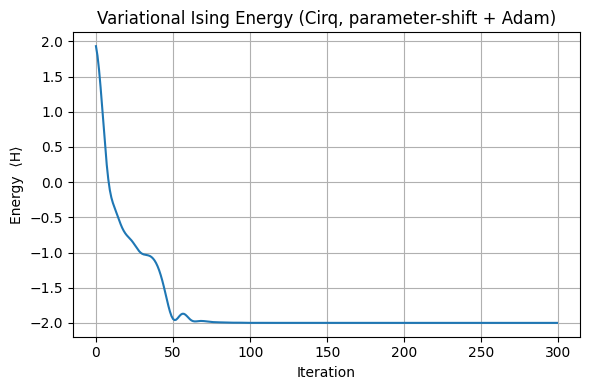

Final ansatz:
 0: ───Rx(0)────────Rz(-0.803π)───@───Rx(0.069π)───Rz(-0.212π)─────────────────@───────
                                 │                                            │
1: ───Rx(-π)───────Rz(0.006π)────X───@────────────Rx(0)─────────Rz(0.393π)────X───@───
                                     │                                            │
2: ───Rx(0.733π)───Rz(-π)────────────X────────────Rx(0.733π)────Rz(-0.063π)───────X───


In [5]:
# ----- Parameter-shift gradient -----
# For Rx/Rz: ∂E/∂α = 0.5 * [E(α + π/2) - E(α - π/2)]
SHIFT = np.pi / 2

def grad_param_shift(params):
    g = np.zeros_like(params)
    it = np.ndindex(params.shape)
    for idx in it:
        params[idx] += SHIFT
        e_plus = energy(params)
        params[idx] -= 2*SHIFT
        e_minus = energy(params)
        params[idx] += SHIFT
        g[idx] = 0.5 * (e_plus - e_minus)
    return g

# ----- Optimize θ by Adam on ⟨H⟩ -----
rng = np.random.default_rng(0)
params = rng.uniform(-0.2, 0.2, size=(layers, n_qubits, 2))  # small init

lr = 0.1
beta1, beta2, eps = 0.9, 0.999, 1e-8
m = np.zeros_like(params)
v = np.zeros_like(params)

steps = 300
energies = []

for t in range(1, steps+1):
    E = energy(params)
    energies.append(E)
    g = grad_param_shift(params)

    # Adam
    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*(g*g)
    mhat = m / (1 - beta1**t)
    vhat = v / (1 - beta2**t)
    params -= lr * mhat / (np.sqrt(vhat) + eps)

    if t % 25 == 0:
        print(f"[iter {t:03d}] E = {E:.6f}")

print(f"Final energy: {energies[-1]:.6f}")

# Plot
plt.figure(figsize=(6,4))
plt.plot(energies)
plt.xlabel("Iteration"); plt.ylabel("Energy  ⟨H⟩")
plt.title("Variational Ising Energy (Cirq, parameter-shift + Adam)")
plt.grid(True); plt.tight_layout(); plt.show()

# Show final circuit
final_circ = build_ansatz(qubits, layers, params)
print("Final ansatz:\n", final_circ)


Noiseless energy: -2.000000
p=0.000  depol ⟨H⟩=-2.000000   amp_damp ⟨H⟩=-2.000000
p=0.005  depol ⟨H⟩=-1.833474   amp_damp ⟨H⟩=-1.833102
p=0.010  depol ⟨H⟩=-1.679907   amp_damp ⟨H⟩=-1.674354
p=0.020  depol ⟨H⟩=-1.407957   amp_damp ⟨H⟩=-1.379554
p=0.050  depol ⟨H⟩=-0.817600   amp_damp ⟨H⟩=-0.649328


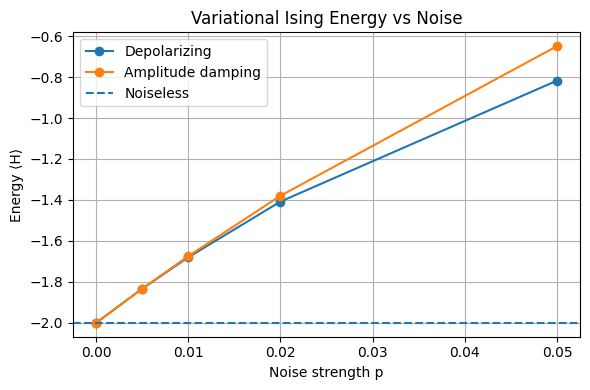

In [6]:
# Noise-aware energy using DensityMatrixSimulator (exact for Markovian channels)
dm_sim = cirq.DensityMatrixSimulator()

def energy_noisy(params, p=0.01, noise_kind="depolarize"):
    """
    ⟨H⟩ under noise. Uses DensityMatrixSimulator so it's exact (no MC needed).
    p: noise strength (e.g., 0.005, 0.01, 0.02, 0.05)
    noise_kind: "depolarize" or "amp_damp"
    """
    circ = build_ansatz(qubits, layers, params)
    if noise_kind == "depolarize":
        noisy_circ = circ.with_noise(cirq.depolarize(p))
    elif noise_kind == "amp_damp":
        noisy_circ = circ.with_noise(cirq.amplitude_damp(p))
    else:
        raise ValueError("noise_kind must be 'depolarize' or 'amp_damp'")

    exp_zz = dm_sim.simulate_expectation_values(noisy_circ, ZZ_terms)
    exp_x  = dm_sim.simulate_expectation_values(noisy_circ, X_terms) if h != 0 else []
    E = J * sum(v.real for v in exp_zz) + h * sum(v.real for v in exp_x)
    return float(E)

# Sweep p and plot
p_values = [0.0, 0.005, 0.01, 0.02, 0.05]
energies_clean, energies_depol, energies_adamp = [], [], []

E_clean = energy(params)
print(f"Noiseless energy: {E_clean:.6f}")

for p in p_values:
    e_dep = energy_noisy(params, p=p, noise_kind="depolarize")
    e_amp = energy_noisy(params, p=p, noise_kind="amp_damp")
    energies_depol.append(e_dep)
    energies_adamp.append(e_amp)
    energies_clean.append(E_clean)

for p, e_dep, e_amp in zip(p_values, energies_depol, energies_adamp):
    print(f"p={p:.3f}  depol ⟨H⟩={e_dep:.6f}   amp_damp ⟨H⟩={e_amp:.6f}")

plt.figure(figsize=(6,4))
plt.plot(p_values, energies_depol, marker='o', label='Depolarizing')
plt.plot(p_values, energies_adamp, marker='o', label='Amplitude damping')
plt.axhline(E_clean, linestyle='--', label='Noiseless')
plt.xlabel("Noise strength p"); plt.ylabel("Energy ⟨H⟩")
plt.title("Variational Ising Energy vs Noise")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


In [7]:
# Save clean (ideal-trained) params for later reuse
import numpy as np
np.save("ising_params_clean.npy", params)
print("Saved ising_params_clean.npy")


Saved ising_params_clean.npy


PHASE 3

[noise-train 020] E≈-1.455245
[noise-train 040] E≈-1.831254
[noise-train 060] E≈-1.645848
[noise-train 080] E≈-1.440072
[noise-train 100] E≈-1.734920
[noise-train 120] E≈-1.777089
[noise-train 140] E≈-1.670819
[noise-train 160] E≈-1.736937
[noise-train 180] E≈-1.860681
[noise-train 200] E≈-1.545300
p=0.005  before=-1.833474  after(noise-trained)=-1.832679
p=0.010  before=-1.679907  after(noise-trained)=-1.679184
p=0.020  before=-1.407957  after(noise-trained)=-1.407359


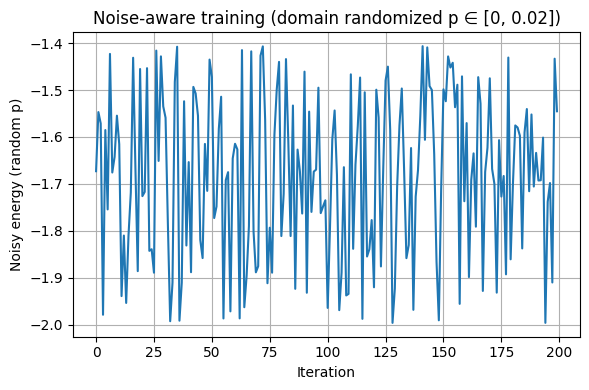

In [8]:
# Phase 3: train under domain-randomized noise
rng = np.random.default_rng(1)
params_dr = params.copy()  # warm start

lr = 0.05
beta1, beta2, eps = 0.9, 0.999, 1e-8
m = np.zeros_like(params_dr)
v = np.zeros_like(params_dr)

steps = 200
energies_dr = []

def energy_randomized(params, p_range=(0.0, 0.02), noise_kind="depolarize"):
    p = rng.uniform(*p_range)
    return energy_noisy(params, p=p, noise_kind=noise_kind)

for t in range(1, steps+1):
    # objective = noisy energy with random p in [0, 0.02]
    E = energy_randomized(params_dr, p_range=(0.0, 0.02), noise_kind="depolarize")
    energies_dr.append(E)

    # parameter-shift gradients on randomized objective
    g = np.zeros_like(params_dr)
    SHIFT = np.pi/2
    it = np.ndindex(params_dr.shape)
    for idx in it:
        params_dr[idx] += SHIFT
        e_plus  = energy_randomized(params_dr, p_range=(0.0, 0.02), noise_kind="depolarize")
        params_dr[idx] -= 2*SHIFT
        e_minus = energy_randomized(params_dr, p_range=(0.0, 0.02), noise_kind="depolarize")
        params_dr[idx] += SHIFT
        g[idx] = 0.5 * (e_plus - e_minus)

    # Adam update
    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*(g*g)
    mhat = m / (1 - beta1**t)
    vhat = v / (1 - beta2**t)
    params_dr -= lr * mhat / (np.sqrt(vhat) + eps)

    if t % 20 == 0:
        print(f"[noise-train {t:03d}] E≈{E:.6f}")

# After noise-aware training, compare at fixed p
for p in [0.005, 0.01, 0.02]:
    e_before = energy_noisy(params,    p=p, noise_kind="depolarize")
    e_after  = energy_noisy(params_dr, p=p, noise_kind="depolarize")
    print(f"p={p:.3f}  before={e_before:.6f}  after(noise-trained)={e_after:.6f}")

plt.figure(figsize=(6,4))
plt.plot(energies_dr)
plt.xlabel("Iteration"); plt.ylabel("Noisy energy (random p)")
plt.title("Noise-aware training (domain randomized p ∈ [0, 0.02])")
plt.grid(True); plt.tight_layout(); plt.show()


In [11]:
# Use higher-precision density-matrix simulator + safe p
import numpy as np, cirq

dm_sim = cirq.DensityMatrixSimulator(dtype=np.complex128)

def energy_noisy(params, p=0.01, noise_kind="depolarize"):
    p = float(np.clip(p, 0.0, 0.25))  # guard
    circ = build_ansatz(qubits, layers, params)
    if noise_kind == "depolarize":
        noisy_circ = circ.with_noise(cirq.depolarize(p))
    elif noise_kind == "amp_damp":
        noisy_circ = circ.with_noise(cirq.amplitude_damp(p))
    else:
        raise ValueError("noise_kind must be 'depolarize' or 'amp_damp'")
    exp_zz = dm_sim.simulate_expectation_values(noisy_circ, ZZ_terms)
    exp_x  = dm_sim.simulate_expectation_values(noisy_circ, X_terms) if h != 0 else []
    return float(J * sum(v.real for v in exp_zz) + h * sum(v.real for v in exp_x))


[robust 020] E≈-1.759581
[robust 040] E≈-1.759642
[robust 060] E≈-1.759668
[robust 080] E≈-1.759673
[robust 100] E≈-1.759673
[robust 120] E≈-1.759673
[robust 140] E≈-1.759673
[robust 160] E≈-1.759673
[robust 180] E≈-1.759673
[robust 200] E≈-1.759673
p=0.005  before=-1.833474  after(robust)=-1.833474
p=0.010  before=-1.679906  after(robust)=-1.679906
p=0.020  before=-1.407957  after(robust)=-1.407957


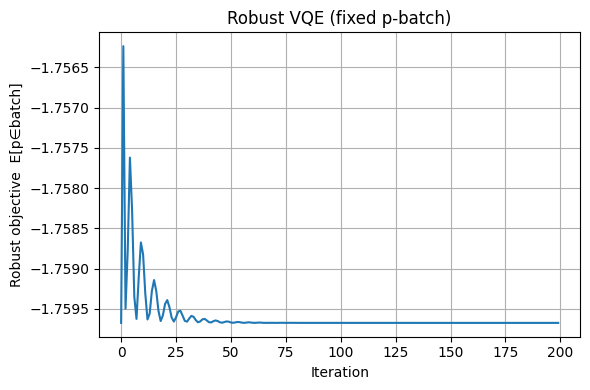

In [12]:
# Fixed p-batch robust VQE (low-variance gradients)
rng = np.random.default_rng(2)
params_rb = params.copy()  # start from the clean-trained params (-2.0)

K = 8
p_batch = rng.uniform(0.0, 0.02, size=K)
SHIFT = np.pi/2

def E_batch(params):
    return np.mean([energy_noisy(params, p=float(p), noise_kind="depolarize") for p in p_batch])

def grad_param_shift_batch(params):
    g = np.zeros_like(params)
    it = np.ndindex(params.shape)
    for idx in it:
        params[idx] += SHIFT
        e_plus = E_batch(params)
        params[idx] -= 2*SHIFT
        e_minus = E_batch(params)
        params[idx] += SHIFT
        g[idx] = 0.5 * (e_plus - e_minus)
    return g

# Adam
lr = 0.03
beta1, beta2, eps = 0.9, 0.999, 1e-8
m = np.zeros_like(params_rb)
v = np.zeros_like(params_rb)

steps = 200
hist = []
for t in range(1, steps+1):
    E = E_batch(params_rb); hist.append(E)
    g = grad_param_shift_batch(params_rb)
    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*(g*g)
    mhat = m / (1 - beta1**t)
    vhat = v / (1 - beta2**t)
    params_rb -= lr * mhat / (np.sqrt(vhat) + eps)
    if t % 20 == 0:
        print(f"[robust {t:03d}] E≈{E:.6f}")

# Compare before vs after at fixed p
for p in [0.005, 0.01, 0.02]:
    e_before = energy_noisy(params,    p=p, noise_kind="depolarize")
    e_after  = energy_noisy(params_rb, p=p, noise_kind="depolarize")
    print(f"p={p:.3f}  before={e_before:.6f}  after(robust)={e_after:.6f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(hist)
plt.xlabel("Iteration"); plt.ylabel("Robust objective  E[p∈batch]")
plt.title("Robust VQE (fixed p-batch)"); plt.grid(True); plt.tight_layout(); plt.show()


[amp robust 020] E≈-1.778060
[amp robust 040] E≈-1.783930
[amp robust 060] E≈-1.785401
[amp robust 080] E≈-1.785893
[amp robust 100] E≈-1.785986
[amp robust 120] E≈-1.785988
[amp robust 140] E≈-1.785989
[amp robust 160] E≈-1.785989
[amp robust 180] E≈-1.785989
[amp robust 200] E≈-1.785989
amp_damp p=0.005  before=-1.833102  after(robust)=-1.846666
amp_damp p=0.010  before=-1.674354  after(robust)=-1.701387
amp_damp p=0.020  before=-1.379554  after(robust)=-1.433296


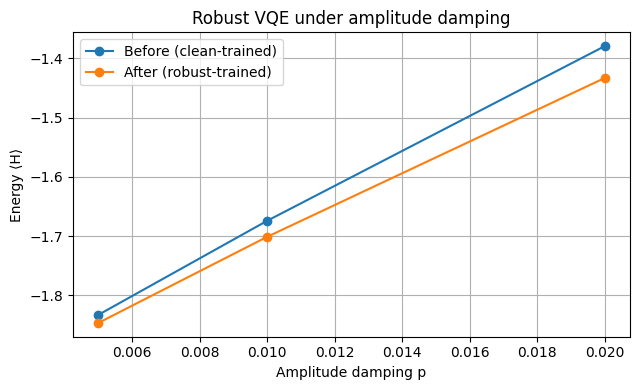

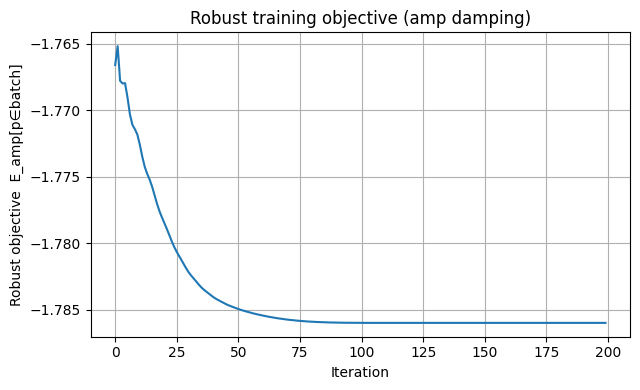

In [13]:
# Robust VQE under amplitude damping (non-unital) — clear "before vs after" win
# Assumes you still have: qubits, layers, J, h, build_ansatz(...), energy_noisy(...) with dm_sim complex128,
# and 'params' from Phase 2 (the clean, -2.0 solution).

import numpy as np, matplotlib.pyplot as plt

rng = np.random.default_rng(3)
params_amp = params.copy()         # start from clean-trained params
K = 8                              # fixed batch of noise levels to stabilize gradients
p_batch = rng.uniform(0.0, 0.02, size=K)
SHIFT = np.pi/2

def E_batch_amp(P):
    return np.mean([energy_noisy(P, p=float(p), noise_kind="amp_damp") for p in p_batch])

def grad_param_shift_batch_amp(P):
    g = np.zeros_like(P)
    it = np.ndindex(P.shape)
    for idx in it:
        P[idx] += SHIFT;  e_plus  = E_batch_amp(P)
        P[idx] -= 2*SHIFT; e_minus = E_batch_amp(P)
        P[idx] += SHIFT
        g[idx] = 0.5*(e_plus - e_minus)
    return g

# Adam on the robust objective
lr, beta1, beta2, eps = 0.03, 0.9, 0.999, 1e-8
m = np.zeros_like(params_amp); v = np.zeros_like(params_amp)
hist = []
for t in range(1, 201):
    E = E_batch_amp(params_amp); hist.append(E)
    g = grad_param_shift_batch_amp(params_amp)
    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*(g*g)
    mhat = m / (1 - beta1**t)
    vhat = v / (1 - beta2**t)
    params_amp -= lr * mhat / (np.sqrt(vhat) + eps)
    if t % 20 == 0: print(f"[amp robust {t:03d}] E≈{E:.6f}")

# Compare before vs after at fixed p values
p_vals = [0.005, 0.01, 0.02]
before = [energy_noisy(params,     p=p, noise_kind="amp_damp") for p in p_vals]
after  = [energy_noisy(params_amp, p=p, noise_kind="amp_damp") for p in p_vals]
for p, b, a in zip(p_vals, before, after):
    print(f"amp_damp p={p:.3f}  before={b:.6f}  after(robust)={a:.6f}")

# Plot (clean + save PNG for slides)
plt.figure(figsize=(6.5,4))
plt.plot(p_vals, before, marker='o', label='Before (clean-trained)')
plt.plot(p_vals, after,  marker='o', label='After (robust-trained)')
plt.xlabel("Amplitude damping p")
plt.ylabel("Energy ⟨H⟩")
plt.title("Robust VQE under amplitude damping")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("robust_vqe_amp_damp.png", dpi=300, bbox_inches="tight")
plt.show()

# Optional: training trace
plt.figure(figsize=(6.5,4))
plt.plot(hist); plt.grid(True)
plt.xlabel("Iteration"); plt.ylabel("Robust objective  E_amp[p∈batch]")
plt.title("Robust training objective (amp damping)"); plt.tight_layout()
plt.savefig("robust_vqe_amp_damp_training.png", dpi=300, bbox_inches="tight")
plt.show()


Mean: clean=-1.655481  robust=-1.684581
Std : clean=0.186405  robust=0.170222
CVaR10% (lower is better): clean=-1.971569  robust=-1.973830


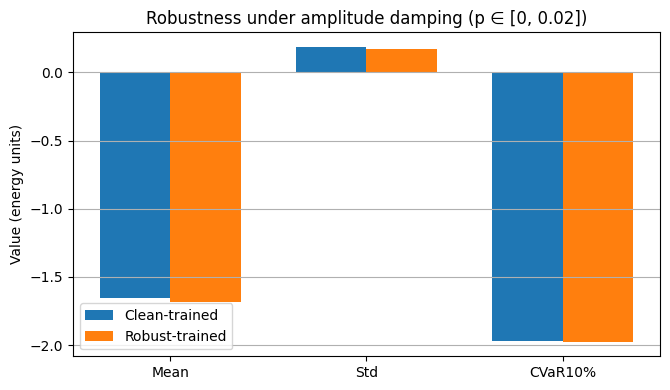

In [14]:
import numpy as np, matplotlib.pyplot as plt, os
os.makedirs("results", exist_ok=True)

def sample_energies(params_, noise_kind="amp_damp", p_low=0.0, p_high=0.02, K=200):
    rng = np.random.default_rng(0)
    Ps = rng.uniform(p_low, p_high, size=K)
    Es = np.array([energy_noisy(params_, p=float(p), noise_kind=noise_kind) for p in Ps])
    return Es

def cvar(values, alpha=0.10):
    v = np.sort(values)              # energy: more negative = better
    k = max(1, int(np.ceil(alpha*len(v))))
    return float(np.mean(v[:k]))     # average of best α fraction

E_clean = sample_energies(params,     noise_kind="amp_damp", K=200)
E_rob   = sample_energies(params_amp, noise_kind="amp_damp", K=200)

m_clean, s_clean, c_clean = float(E_clean.mean()), float(E_clean.std()), cvar(E_clean, 0.10)
m_rob,   s_rob,   c_rob   = float(E_rob.mean()),   float(E_rob.std()),   cvar(E_rob,   0.10)

print(f"Mean: clean={m_clean:.6f}  robust={m_rob:.6f}")
print(f"Std : clean={s_clean:.6f}  robust={s_rob:.6f}")
print(f"CVaR10% (lower is better): clean={c_clean:.6f}  robust={c_rob:.6f}")

labels = ["Mean", "Std", "CVaR10%"]
clean_vals = [m_clean, s_clean, c_clean]
rob_vals   = [m_rob,   s_rob,   c_rob]
x = np.arange(len(labels)); w = 0.36
plt.figure(figsize=(6.8,4))
plt.bar(x-w/2, clean_vals, width=w, label="Clean-trained")
plt.bar(x+w/2, rob_vals,   width=w, label="Robust-trained")
plt.xticks(x, labels); plt.ylabel("Value (energy units)")
plt.title("Robustness under amplitude damping (p ∈ [0, 0.02])")
plt.grid(True, axis="y"); plt.legend(); plt.tight_layout()
plt.savefig("results/robust_metrics_cvar.png", dpi=300, bbox_inches="tight")
plt.show()
